<a href="https://colab.research.google.com/github/Koushikgoud/Machine-Learning/blob/main/NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PA1 - NB Classification
In this, we implemented a simple Naive Bayes classifier and train/test it on the 20 newsgroup dataset. The objective is to classify documents into one of the 20 categories using a simple Naive Bayesian method.

The following code is partially done. You need to complete all the code blocks that start with **TODO**. Save a copy of this notebook, and complete your notebook. **Submit a PDF copy of your notebook to D2L.**

## Data Analysis
Fetching the dataset first. You can download it using a sci-kit learn dataset method as below.

In [1]:
from sklearn.datasets import fetch_20newsgroups

data_tr = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

Let's inspect what we have.

In [2]:
dir(data_tr)

['DESCR', 'data', 'filenames', 'target', 'target_names']

Let's print out the first three examples.

In [3]:
data_tr.data[:5]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [4]:
data_tr.target

array([7, 4, 4, ..., 3, 1, 8])

As you can see, `data` is the textual input, and `target` is the corresponding label (i.e., news category). We have 20 classes as below, and the target is the integer number corresponding to the names:

In [5]:
data_tr.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's plot a histogram with the target data to see its distribution.

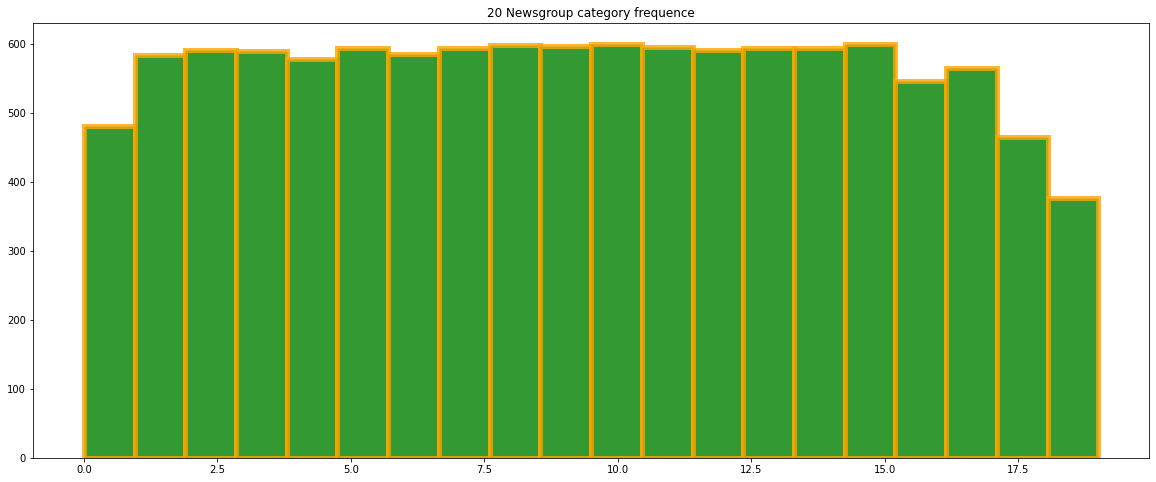

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8)) #change your figure size as per your desire here
n,bins,patch = plt.hist(data_tr.target, bins=len(data_tr.target_names), color='green', alpha=0.8, label='Value', edgecolor='orange', linewidth=5)
plt.title("20 Newsgroup category frequence")


## Text preprocessing

### Filtering of Stopwords and Tokenizing

You will remove stopwords from the raw texts. *Stopwords* are a set of frequently used words in any language, such as 'a', 'you', 'I', and 'will'. These are most likely function words that are not necessarily informative in delivering meanings.

Next, the given texts will be tokenized; that is, a sentence is split into an array of words by whitespace. After that, we can compute the probabilities over words. 

So, this is a simple text preprocessing that should:
- convert to lowercase
- filter stopwords, and
- tokenize simply by whitespace.

We can use the NLTK stopwords as below:

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw_list = stopwords.words('english')
sw_list[:10]  # show some examples


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

First, we are using WhitespaceTokenizer module from nltk.tokenize library which simply breaks the sentences whenever it comes across a whitespace and we are applying this after converting the text to lowercase.
Next we remove the stopwords.
  

In [8]:
# import WhitespaceTokenizer() method from nltk
from nltk.tokenize import WhitespaceTokenizer
     
# Create a reference variable for Class WhitespaceTokenizer
tokenizer = WhitespaceTokenizer()
nltk.download('punkt')

def text_prep(s):
  #converting to lowercase and tokenizing the documents 
  tokenized_data = tokenizer.tokenize(s.lower())

  #removing stopwords
  s_no_sw = [word for word in tokenized_data if word not in sw_list]

  return s_no_sw


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Apply the function `text_prep` on `data_tr.data` and append the outputs to `data_tr_prep`. `data_tr_prep` will be a list of documents where each document is a list of preprocessed words.

In [9]:
data_tr_prep = []
for i in range(len(data_tr.data)):
  data_tr_prep.append(text_prep(data_tr.data[i]))
data_tr_prep[0][:12]

['from:',
 'lerxst@wam.umd.edu',
 "(where's",
 'thing)',
 'subject:',
 'car',
 'this!?',
 'nntp-posting-host:',
 'rac3.wam.umd.edu',
 'organization:',
 'university',
 'maryland,']

`data_tr_prep[0]` should print a list of words similar to the following list:
```
['from:',
 'lerxst@wam.umd.edu',
 "(where's",
 'thing)',
 'subject:',
 'car',
 'this!?',
 'nntp-posting-host:',
 'rac3.wam.umd.edu',
 'organization:',
 'university',
 'maryland,',
 ...
]
```

## Build a Vocabulary

Now we need to build a vocabulary which contains a fixed number of unique words. Only the words in the vocabulary will be used in the prediction process.

Let's set a reasonable size of vocabulary (i.e., V = 10000)

We will use a Python Counter to count all the words appear in the entire *training* dataset. This counter is a dictionary of key-value (word-frequency) pairs.


In [10]:
from collections import Counter, defaultdict
V = 10000
C = len(data_tr.target_names) #20
cnt_words = Counter()
for d in data_tr_prep:
  cnt_words.update(d)

`.most_common(n)` will return the n most frequent words in the counter, as below: Let's not worry about the punctuation words for now. 

In [11]:
cnt_words.most_common(30)

[('>', 27843),
 ('subject:', 11644),
 ('from:', 11590),
 ('lines:', 11337),
 ('organization:', 10881),
 ('|', 10072),
 ('-', 9662),
 ('would', 8654),
 ('re:', 7857),
 ('--', 7639),
 ('writes:', 7505),
 ('one', 7481),
 ('|>', 6521),
 ('article', 6466),
 ('like', 5345),
 ('x', 4982),
 ('people', 4859),
 ('get', 4785),
 ('nntp-posting-host:', 4777),
 (':', 4710),
 ('university', 4597),
 ('know', 4295),
 ('>>', 4140),
 ('*', 4094),
 ('think', 4075),
 ('use', 3784),
 ('new', 3649),
 ('also', 3491),
 ('could', 3370),
 ('1', 3345)]

Build mappings between tokens (words) and their index numbers.**

We create a data structure for the vocabulary of `V` words. You can use `cnt_words.most_common(V)` to get the top V most frequent words.

`tok2idx` will map a token to its index number and `idx2tok` will be a list of words in the frequency order.

In [12]:
idx2tok = list()
tok2idx = dict()

#Populate the idx2tok and tok2idx
for i in range(10000):
  idx2tok.append(cnt_words.most_common(V)[i][0])
  tok2idx[cnt_words.most_common(V)[i][0]] = i

print(len(idx2tok));

10000


In [58]:
idx2tok[:10]

['>',
 'subject:',
 'from:',
 'lines:',
 'organization:',
 '|',
 '-',
 'would',
 're:',
 '--']

In [60]:
tok2idx['would']

7

You should see results like below:

```
> idx2tok[:10]

['>',
 'subject:',
 'from:',
 'lines:',
 'organization:',
 '|',
 '-',
 'would',
 're:',
 '--']

> tok2idx['would']

7
 ```

## Training a NB Classifier

Naive Bayes classifier is a simple conditional probability model based on applying Bayes' theorem with strong feature independence assumption. For more details, you should carefully read the lecture slides.

In essense, we need to build a classifier that computes the following:

$$argmax_{c\in C} P(c)\prod_{w\in d} P(w|c)$$

That is, for each class $c$, we compute the product of the class prior $P(c)$ and the conditional probabilities of words given the class $P(w|c)$ in a document $d$.

To do this, we need to estimate the prior class probabilities $P(c)$ and the conditional probabilities $P(w|c)$. We will use the normalized frequencies to estimate these probabilities.

For example, $P(c=rec.autos)$ can be estimated by the number of documents that belong to the class divided it by the total number of documents.

Likewise, $P(w=car|c=rec.autos)$ can be estimated by the fraction of the word $w$ appears among all words in documents of the class $c$.

To handle the zero probability issue, you should also apply the 'add-1' smoothing (also called as Laplace smoothing).

Now, the following Numpy arrays (i.e, `cond_prob` and `prior_prob`) will contain the estimated probabilities.

In [13]:
import numpy as np

cond_prob = np.zeros((V, C))
prior_prob = np.zeros((C))
len(cond_prob)

10000

Increment the counts and normalize them properly so that they can be use as the probabilities.**

Prior probability of class, c = P(c) = Number of documents belonging to class, c / total number of documents available in the corpus

---



In [14]:
# Prior probabilities step-1
counts = []
count = 0
target = 0
doc_len = 0
for i in range(20):
  for d, c in zip(data_tr_prep, data_tr.target):
    if c == i:
      count += 1
  counts.append(count)
  count = 0 
  target += 1

In [15]:
# Prior probabilities step-2
for i in range(len(counts)):
  prior_prob[i] = counts[i]/11314;

In [16]:
prior_prob

array([0.04242531, 0.05161747, 0.05223617, 0.05214778, 0.05108715,
       0.05241294, 0.05170585, 0.05250133, 0.05285487, 0.05276648,
       0.05303164, 0.05258971, 0.05223617, 0.05250133, 0.05241294,
       0.05294326, 0.04825879, 0.04984974, 0.04109952, 0.03332155])

Here, we are simply getting the frequencies of occurence of each word in each of 20 categories/classes

In [17]:
# Conditional probabilities step-1
cnt = Counter()
word_count = []
for i in range(20):
  for d, c in zip(data_tr_prep, data_tr.target):
      if c == i:
        cnt.update(d)
  word_count.append(cnt)
  cnt = Counter()
word_count[10]["would"]


419

Here, we are calculating the total number of words present in each class which will used for normalizing the probabilities

In [18]:
# Conditional probabilities step-2
all_class_word_counts = []
for i in range(len(word_count)):
  class_word_count = 0
  for word in idx2tok:  
    class_word_count += word_count[i][word]
  all_class_word_counts.append(class_word_count)
all_class_word_counts

[70964,
 60492,
 53100,
 57785,
 50195,
 84937,
 42926,
 59425,
 54491,
 60432,
 89825,
 103669,
 56887,
 74895,
 80958,
 90081,
 90032,
 117600,
 91113,
 55170]

Here, we are calculating the conditional probability of each word present in the idx2tok (Remember that idx2tok is a list of most frequent 10000 words present in the corpus)

In [19]:
# Conditional probabilities step-3
for i in range(20):
    for word, word_idx in zip(idx2tok, range(len(idx2tok))):
      cond_prob[word_idx][i] = (word_count[i][word] + 1) / (all_class_word_counts[i] + 10000 )
    cond_prob[i]

Conditional probability of word, w in class c = 𝑃(𝑤|𝑐) = ((count of word,w in class, c) + 1 ) / (Total number of words in class, c + Vocabulary count )

In [20]:
cond_prob[10]

array([0.00662023, 0.0033479 , 0.00435816, 0.00343734, 0.00426946,
       0.00213826, 0.00113366, 0.00668347, 0.00765998, 0.00607678,
       0.00407713, 0.00402045, 0.00439547, 0.00508864, 0.00474944,
       0.00379692, 0.00492842, 0.00417712, 0.00568671, 0.00515575])

## Inference

You will test your classifier with unseen examples (test dataset). 

Apply `text_prep` on `data_ts` in the same way as we did earlier.**

In [22]:
data_ts = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)
data_ts_prep = []
# Apply text_prep on data_ts and fill in data_ts_prep
for i in range(len(data_ts.data)):
  data_ts_prep.append(text_prep(data_ts.data[i]))
data_ts_prep[0][:12]

['from:',
 'v064mb9k@ubvmsd.cc.buffalo.edu',
 '(neil',
 'b.',
 'gandler)',
 'subject:',
 'need',
 'info',
 '88-89',
 'bonneville',
 'organization:',
 'university']

Now, *make a prediction*.

For each test document, compute the "argmax" formula shown earlier. The argmax should tell you the class that maximizes the product of the prior/conditional probabilities. 

You should apply log to the product for computational stability and less expansive computation. Computer prefers addition to multiplication.


In [ ]:
import math

pred = []
for d, c in zip(data_ts_prep, data_ts.target):
  # implementing this for loop to make predictions
  probs = []
  for class_name in range(len(data_ts.target_names)):
    prob = math.log(prior_prob[class_name])
    for word in d:
      if word in idx2tok:
        prob = prob + math.log(cond_prob[tok2idx[word], class_name]) 
    probs.append(prob)
  max_value = max(probs)
  pred.append([index for index, item in enumerate(probs) if item == max_value])  

In [51]:
preds = np.zeros(len(pred))
for i in range(len(pred)):
  preds[i] = pred[i][0]


Once, you made all the predictions for the testing examples, you can run a evaluation metric for accuracy.

If everything is correct, we are getting about 77% accuracy.

To measure the accuracy, we are using accuracy_score module from sklearn.metrics library.


In [53]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(data_ts.target, preds)
print(f"Accuracy Score: {round(acc*100, 2)}%")

Accuracy Score: 76.29%


Text(0.5, 1.0, 'Predictions v/s Ground Truth')

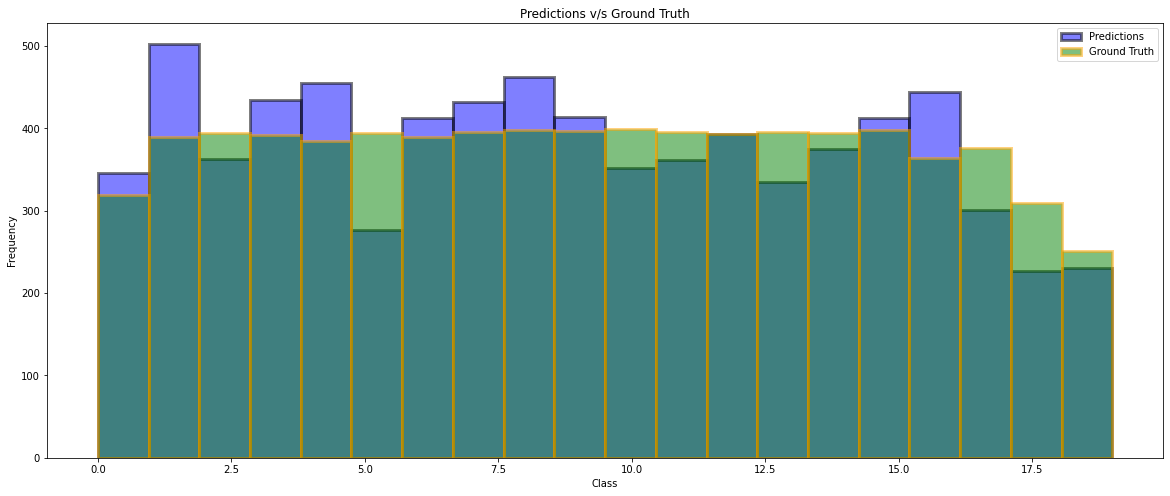

In [57]:
plt.figure(figsize=(20,8)) #change your figure size as per your desire here
plt.hist(preds, len(data_ts.target_names), color='blue', alpha=0.5, label='Predictions', edgecolor='black', linewidth=3)
plt.hist(data_ts.target, len(data_ts.target_names), color='green', alpha=0.5, label='Ground Truth', edgecolor='orange', linewidth=3)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.title("Predictions v/s Ground Truth")